In [2]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.63GB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

/tmp/ipython-input-3330320704.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


In [6]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [7]:
# os.listdir('/content/train')

['neutral', 'angry', 'sad', 'surprise', 'fear', 'happy', 'disgust']

In [8]:
def count_files_in_subdirs(directory,setname):
  # print(os.listdir(directory))

  counts={}

  for subdir in os.listdir(directory):
    subdir_path=os.path.join(directory,subdir)

    if os.path.isdir(subdir_path):
      count=len(os.listdir(subdir_path))
      counts[subdir]=count

  df=pd.DataFrame(counts,index=[setname])
  return df


In [9]:
train_path='/content/train/'
test_path='/content/test/'

In [10]:
data_train=count_files_in_subdirs(directory=train_path,setname='train')

In [11]:
data_train

,neutral,angry,sad,surprise,fear,happy,disgust
train,4965,3995,4830,3171,4097,7215,436


In [12]:
data_test=count_files_in_subdirs(directory=test_path,setname='test')

In [13]:
data_test

,neutral,angry,sad,surprise,fear,happy,disgust
test,1233,958,1247,831,1024,1774,111


<Axes: >

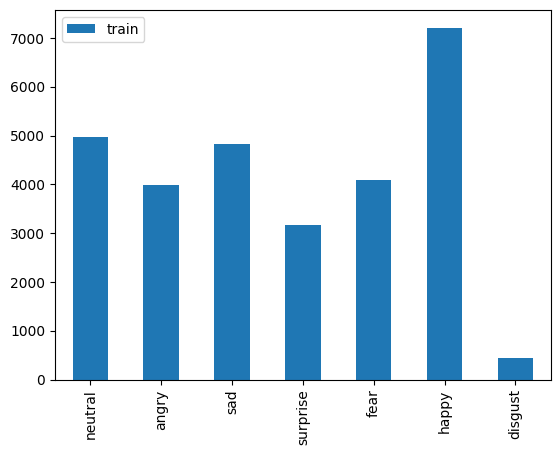

In [14]:
data_train.transpose().plot(kind='bar')

## Plotting one image from each emotion.

In [15]:
emotions=os.listdir(train_path)

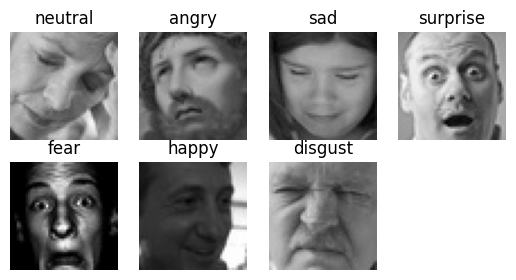

In [16]:
for i,emotion in enumerate(emotions,1):
  path=os.path.join(train_path,emotion)
  img_path=os.listdir(path)[10]
  img=load_img(os.path.join(path,img_path))
  # plt.subplot(3,4,i)
  # plt.imshow(img)
  # plt.title(emotion)
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

## Plotting Random Images From Given Directory

In [17]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

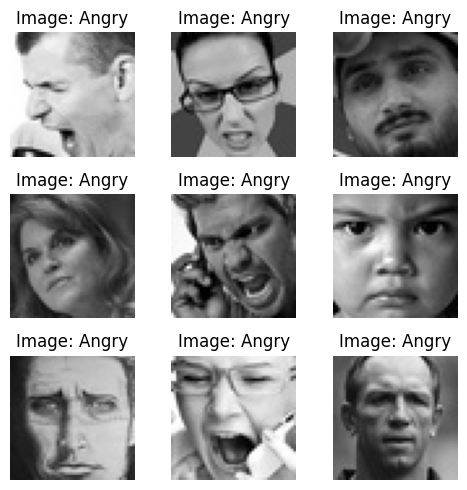

In [18]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

## Checking shapes and channels.

In [19]:
import cv2

In [20]:
image_path='/content/train/happy/Training_10070997.jpg'

In [21]:
img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

In [22]:
img.shape

(48, 48)

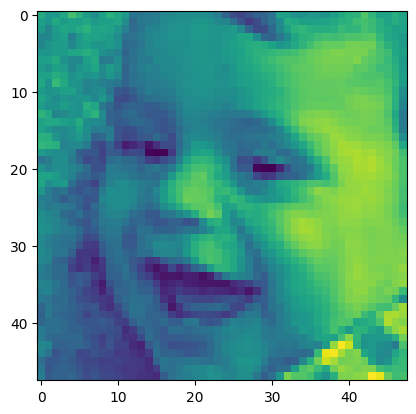

In [23]:
plt.imshow(img)

## Initializing ImageGenerators

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
image_width=48
image_height=48
batch=64
epochs=10
num_classes=7

In [26]:
train_data_path='/content/train/'
test_data_path='/content/test/'

In [27]:
image_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [28]:
from numpy.random import shuffle
train_generator=image_generator.flow_from_directory(
    directory=train_data_path,
    target_size=(image_width,image_height),
    batch_size=batch,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator=image_generator.flow_from_directory(
    directory=train_data_path,
    target_size=(image_width,image_height),
    batch_size=batch,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [29]:
from ctypes.util import test
test_generator=image_generator.flow_from_directory(
    directory=test_data_path,
    target_size=(image_width,image_height),
    batch_size=batch,
    color_mode='grayscale',
    class_mode='categorical',
    )

Found 7178 images belonging to 7 classes.


In [30]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [31]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [32]:
validation_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture Building

In [47]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(image_width,image_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))






/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

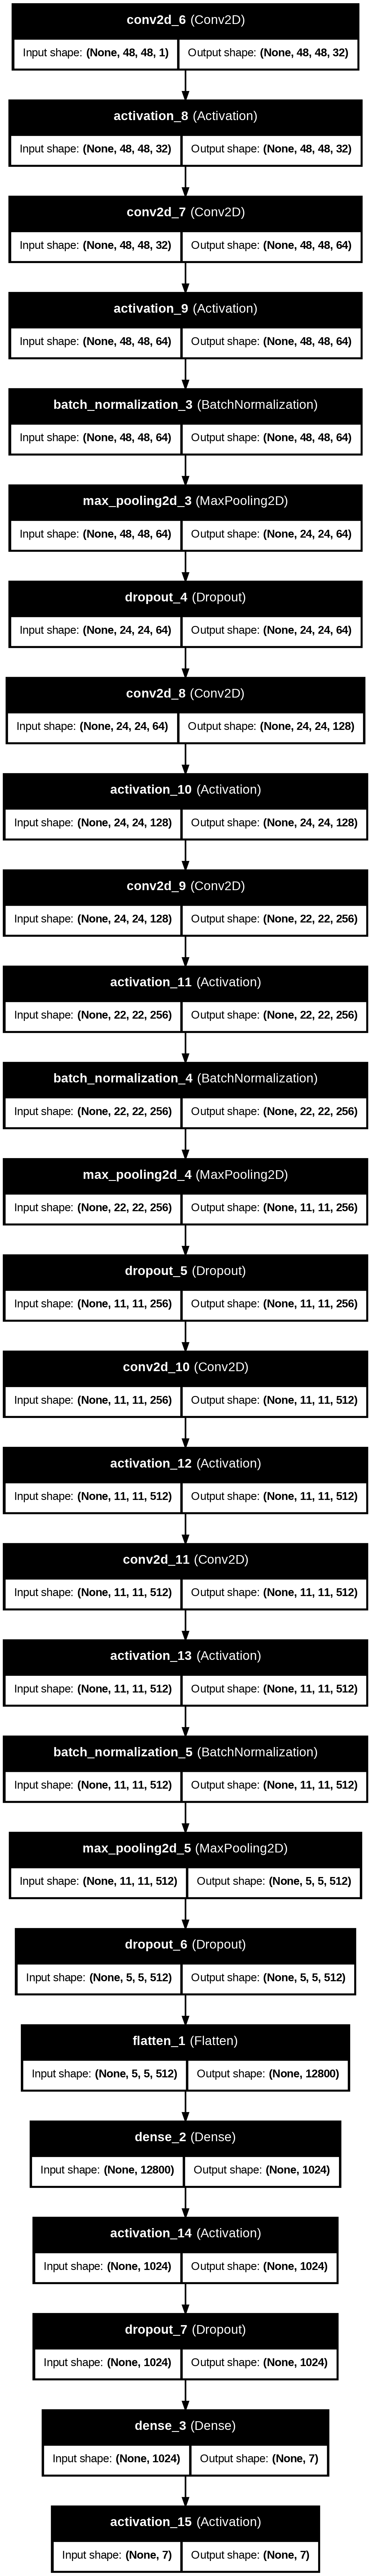

In [49]:
plot_model(model,show_shapes=True,show_layer_names=True,to_file='/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png')

In [50]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Calculating Steps for epoch

In [51]:
train_generator.samples

22968

In [52]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

## Callbacks

In [53]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger

In [54]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [55]:
earlystopping=EarlyStopping(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            restore_best_weights=True,
                            min_delta=0)

In [56]:
model_checkpoint=ModelCheckpoint(chk_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

In [57]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [58]:
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [59]:
# Aggregating all callbacks into a list
callbacks = [earlystopping, model_checkpoint, reduce_lr, csv_logger]  # Adjusted as per your use-case

## Model Training

In [60]:
# history=model.fit(train_generator,epochs=50,steps_per_epoch=train_steps_per_epoch,validation_data=validation_generator,validation_steps=validation_steps_epoch,callbacks=callbacks)
history=model.fit(train_generator,epochs=50,steps_per_epoch=train_steps_per_epoch,validation_data=validation_generator,validation_steps=validation_steps_epoch)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.2151 - loss: 12.7442 - val_accuracy: 0.1427 - val_loss: 18.3192
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2968 - loss: 2.4047 - val_accuracy: 0.3283 - val_loss: 2.0151
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3168 - loss: 1.9468 - val_accuracy: 0.3355 - val_loss: 2.6079
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3451 - loss: 1.8632 - val_accuracy: 0.3424 - val_loss: 1.8605
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3793 - loss: 1.7441 - val_accuracy: 0.4003 - val_loss: 1.6294
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3964 - loss: 1.6748 - val_accuracy: 0.1491 - val_loss: 3.7201
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4071 - loss: 1.7554 - val_accuracy: 0.4229 - val_loss: 1.6293
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4360 - loss: 1.6091 - val_a

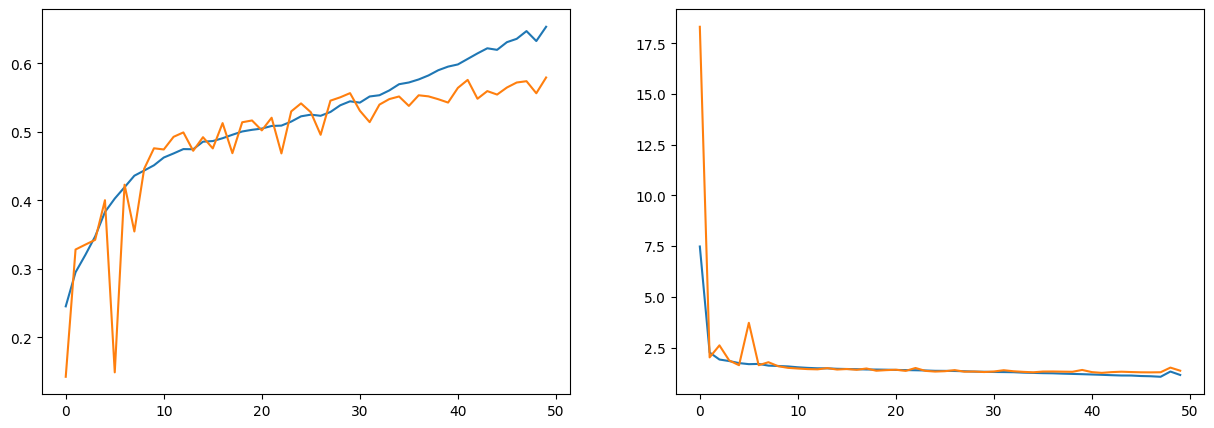

In [61]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
axes[0].plot(history.history['accuracy'],label='Training Accuracy',)
axes[0].plot(history.history['val_accuracy'],label='Validation Accuracy')

axes[1].plot(history.history['loss'],label='Training Loss')
axes[1].plot(history.history['val_loss'],label='Validation Loss')


## Model Evaluation

In [62]:
y_pred=model.predict(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [66]:
y_pred=np.argmax(y_pred,axis=1)

In [67]:
y_pred

array([3, 6, 3, ..., 2, 2, 6])

In [62]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7678 - loss: 0.8343
  4/113 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5505 - loss: 1.3661

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5943 - loss: 1.3128
final train accuracy = 76.77 , validation accuracy = 59.08


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


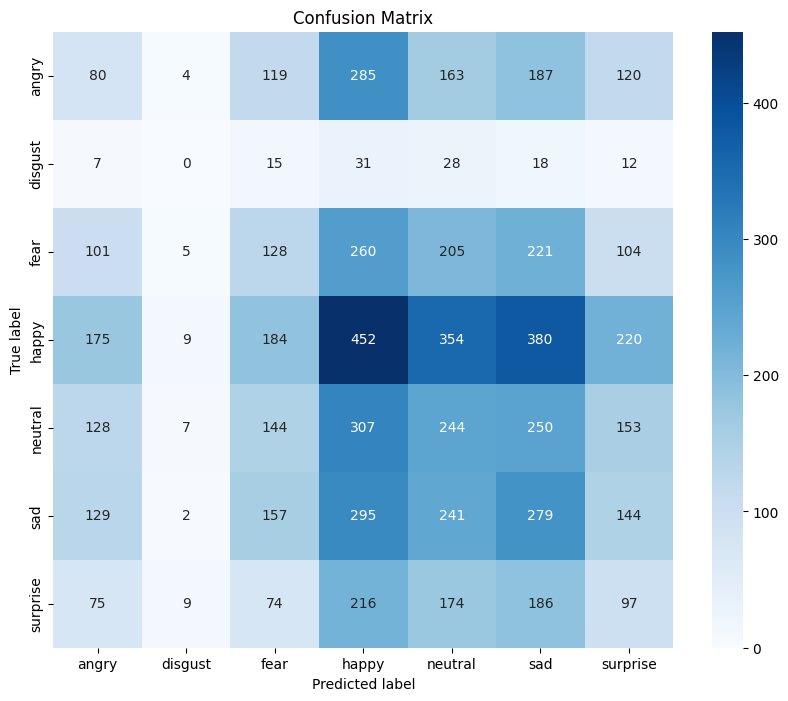

In [63]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

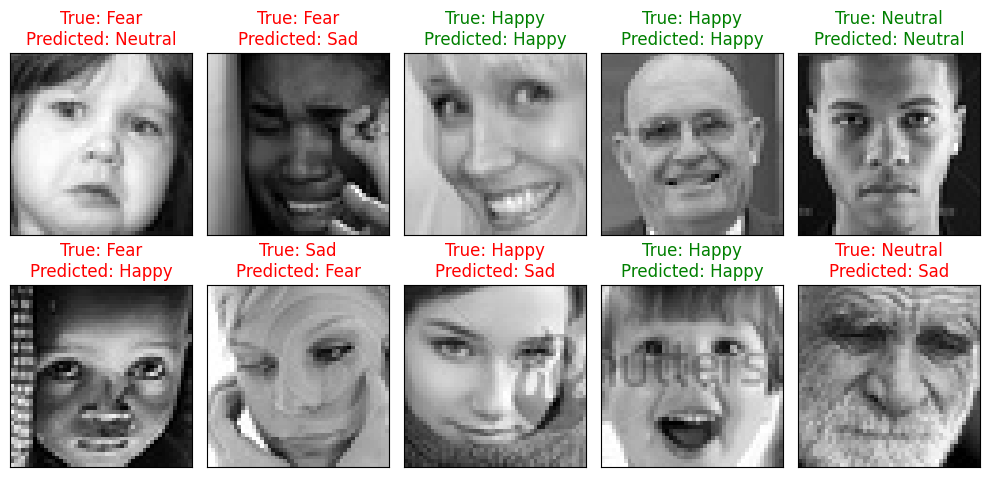

In [67]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Re-training a model with Data Augmentation

In [69]:
image_generator=ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

In [70]:
train_generator=image_generator.flow_from_directory(
    train_path,
    target_size=(image_width,image_height),
    batch_size=batch,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)
test_generator=image_generator.flow_from_directory(
    train_path,
    target_size=(image_width,image_height),
    batch_size=batch,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [71]:
# test_generator=image_generator.flow_from_directory(
#     train_path,
#     target_size=(image_width,image_height),
#     batch_size=batch,
#     color_mode='grayscale',
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

In [72]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1

In [78]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer='glorot_uniform',padding='same',input_shape=(image_width,image_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.L2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))






/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [80]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [81]:
history=model.fit(train_generator,epochs=50,steps_per_epoch=train_steps_per_epoch,validation_data=validation_generator,validation_steps=validation_steps_epoch)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.2143 - loss: 12.3273 - val_accuracy: 0.2513 - val_loss: 10.9487
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.2488 - loss: 2.2851 - val_accuracy: 0.2059 - val_loss: 2.4044
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2357 - loss: 1.9883 - val_accuracy: 0.1571 - val_loss: 10.6142
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2535 - loss: 2.2038 - val_accuracy: 0.1557 - val_loss: 12.4768
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2453 - loss: 1.8682 - val_accuracy: 0.2513 - val_loss: 2.0193
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2525 - loss: 1.8629 - val_accuracy: 0.2480 - val_loss: 1.8376
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2455 - loss: 1.8375 - val_accuracy: 0.2520 - val_loss: 1.8145
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2480 - loss: 1.838